# Normalizing flows



Name: Azmi Haider  
ID: --------

### Import libraries

In [ ]:
## Standard libraries
import os
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-16-08983a184527>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


<Figure size 640x480 with 0 Axes>

### Download Mnist dataset:

In [ ]:
# Transformations applied on each image
def cont(sample):
    sample_cont = np.array(sample, dtype=np.float32) + np.random.uniform(0, 1, size=sample.size)
    return sample_cont / 256.0

# add uniform noise in the range of [0; 1], and then scale them from [0; 256] to [0; 1].
transform = transforms.Compose([cont, transforms.ToTensor()])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
img, label = train_set[0]
print(f"image shape = {img.shape}")
print(f"values [{img.min()}, {img.max()}]")


image shape = torch.Size([1, 28, 28])
values [2.157077001407187e-05, 0.9970675477701127]


A good practice is to always visualize some data examples to get an intuition of the data:

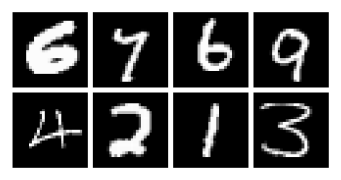

In [ ]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

# NF - Normaling flows





The input image should be
attened and treated as a vector.
- The model needs to be composed of 4 normalizing
flow (NF) layers, each using an MLP with 5 linear
layers and Relu activation functions.
- Before each NF layer, split the input vector into two halves and use one half as the input to the layer,
and the other half as the values that are copied over to the next layer (this is the "coupling layers" we
saw in class). Alternate the roles of the two halves in consecutive NF layers.
- At the end of each NF layer, multiply the output with a scaling factor exp($s_i$) where $s_i$ are learned
parameters in the dimension of the data, for each NF layer i.
- Implement a forward function that maps input data points x into their latent representation z. The
function needs to return the mapped latents z, and the log determinant of the Jacobian of the mapping.
- Implement an inverse function that maps latent vectors z into data samples x. The function needs to
return the data samples.
- Implement a function calc likelihood that will be used to train the model.
- Implement a function sample that will be used to generate samples.
- Use a Standard Gaussian distribution N(0; I) as the prior over z.
Assignments

### The model

### MLP
The basic building block is the MLP to be used in the NF layer

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ru1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ru2 = nn.LeakyReLU(0.2)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.ru3 = nn.LeakyReLU(0.2)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.ru4 = nn.LeakyReLU(0.2)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = self.ru1(self.fc1(x))
        x = self.ru2(self.fc2(x))
        x = self.ru3(self.fc3(x))
        x = self.ru4(self.fc4(x))
        x = self.fc5(x)
        return x

### NF layer
The NF layer with additive coupling and scaling.  
$m$ is the MLP defined above.  
$s_i$ is the scaling factor  


In [ ]:
class NF_Coupling_Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NF_Coupling_Layer, self).__init__()
        self.half_indim = input_dim // 2
        self.m = MLP(self.half_indim, hidden_dim)
        self.si = nn.Parameter(torch.randn(1, input_dim), requires_grad=True)

    def forward(self, x, log_det_jacobian_total, alternate_roles=False):
        x1, x2 = x[:, :self.half_indim], x[:, self.half_indim:]
        if not alternate_roles:
            y1, y2 = x1, x2 + self.m(x1)
        else:
            y1, y2 = x1 + self.m(x2), x2
        y = torch.cat((y1, y2), dim=1)

        y = y * torch.exp(self.si)

        log_det_jacobian_total += torch.sum(self.si)  # Compute the log determinant of the Jacobian

        return y, log_det_jacobian_total

    def inverse(self, y, alternate_roles=False):
        # Undo learned scaling factor
        y = y.to(self.si.device)
        y = y * torch.exp(-self.si)

        y1, y2 = y[:, :self.half_indim], y[:, self.half_indim:]
        if not alternate_roles:
            x1, x2 = y1, y2 - self.m(y1)
        else:
            x1, x2 = y1 - self.m(y2), y2

        x = torch.cat((x1, x2), dim=1)

        return x


### The normalizing flow model

In [ ]:

class NormalizingFlow(pl.LightningModule):
    def __init__(self, input_dim=784, hidden_dim=1000, num_flows=4):
        super(NormalizingFlow, self).__init__()
        self.flows = nn.ModuleList([NF_Coupling_Layer(input_dim, hidden_dim) for _ in range(num_flows)])
        # prior on latents z
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        self.register_buffer('log_2pi', torch.tensor(math.log(2 * math.pi)))

        # loggin
        self.train_ll_t = []
        self.train_ll = []

        self.val_ll_t = []
        self.val_ll = []

    def forward(self, x):
        # flatten x
        b = x.shape[0]
        x = x.float().reshape(b, -1)

        log_det_jacobian_total = 0
        alternate_roles = False
        for flow in self.flows:
            x, log_det_jacobian_total = flow(x, log_det_jacobian_total, alternate_roles)
            alternate_roles = not alternate_roles  # Alternate the roles of x1 and x2
        return x, log_det_jacobian_total

    def inverse(self, z):
        alternate_roles = True  # Determine initial flip state based on the number of flows
        for flow in reversed(self.flows):
            z = flow.inverse(z, alternate_roles)
            alternate_roles = not alternate_roles  # Alternate the roles of x1 and x2
        return z

    def log_prob_standard_normal(self, z):
        dim = z.size(1)  # Assuming z is a batch of vectors of shape (batch_size, dim)
        log_pzi = - 0.5*torch.sum(z ** 2, dim=1) - 0.5 * self.log_2pi
        return log_pzi # output of shape (batch_size,)

    def calc_likelihood(self, x):
        z, log_det_J = self(x)
        b = z.size(0)
        #log_pz = self.log_prob_standard_normal(z)
        #loss = - log_pz + log_det_J
        #log_pz2 = self.prior.log_prob(z).sum(dim=1)

        #one = torch.tensor([1]).to(z.device)
        log_pz = -(F.softplus(z) + F.softplus(-z))
        log_pz = torch.sum(log_pz, dim=1)

        log_px = log_det_J + log_pz
        # Calculating bits per dimension
        return -log_px.mean()

    def sample(self, num_samples):
        z = torch.randn(num_samples, 784)  # Sample from a standard normal distribution
        #z = Uniform(0, 1).sample((num_samples, 784))
        #z = torch.log(z) - torch.log(1. - z)

        samples = self.inverse(z)  # Apply inverse transformations to generate samples
        samples = samples.reshape(num_samples, 1, 28, 28)
        return samples

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, _ = batch
        loss = self.calc_likelihood(x)
        self.log('train_loss', loss, prog_bar=True)
        self.train_ll.append(-loss.detach().item())
        return loss

    def on_train_epoch_end(self):
        self.train_ll_t.append(np.mean(self.train_ll))
        self.train_ll = []

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        loss = self.calc_likelihood(x)
        self.val_ll.append(-loss.detach().item())
        self.log('val_loss', loss, prog_bar=True)

    def on_validation_epoch_end(self):
        self.val_ll_t.append(np.mean(self.val_ll))
        self.val_ll = []

    def test_step(self, batch, batch_idx):
        x, _ = batch
        loss = self.calc_likelihood(x)
        self.log('test_loss', loss, prog_bar=True)
        return loss

    def gradual_transform(self, num_samples):
        z = torch.randn(num_samples, 784).to(self.device)  # Sample from a standard normal distribution
        alternate_roles = True  # Determine initial flip state based on the number of flows
        intermediate_z = []
        intermediate_z.append(z)
        for flow in reversed(self.flows):
            z = flow.inverse(z, alternate_roles)
            alternate_roles = not alternate_roles  # Alternate the roles of x1 and x2
            intermediate_z.append(z)
        return intermediate_z

### Training loop

To train the model, we again can rely on PyTorch Lightning and write a function below for loading the pretrained model if it exists. To reduce the computational cost, we have saved the validation and test score in the checkpoint already:

In [ ]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "NF"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=25,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                                    LearningRateMonitor("epoch")])

    # Check whether pretrained model exists. If yes, load it and skip training

    pretrained_filename = os.path.join(CHECKPOINT_PATH, "NF")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NormalizingFlow.load_from_checkpoint(pretrained_filename)
    else:
        model = NormalizingFlow()
        trainer.fit(model, train_loader, val_loader)
    model = model.to(device)
    result = trainer.test(model, test_loader, verbose=False)
    return model, result

### Training

train the model for 25 epochs

In [ ]:
model, result = train_model()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | flows | ModuleList | 15.2 M | train
---------------------------------------------
15.2 M    Trainable params
0         Non-trainable params
15.2 M    Total params
60.627    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

# section 1: show plots and visualize samples from trained model

### Plot results

The loss is the negative log likelihood, so the likelihood is just taking the opposite. The results were saved during training for train/val. Results might have needed normalization but the shape (increasing likelihood/decreasing negative likelihood) wouldn't be affected.

[{'test_loss': -2052.6318359375}]


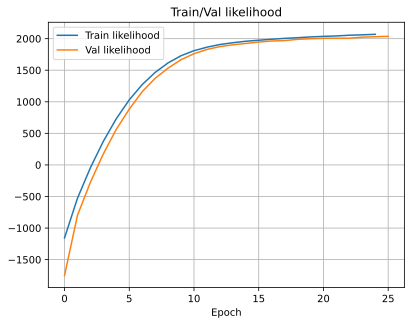

In [ ]:
print(result)

plt.figure()
plt.plot(model.train_ll_t, label='Train likelihood')
plt.plot(model.val_ll_t, label='Val likelihood')

plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.title('Train/Val likelihood')
plt.show()


### Visualize samples
We visualize 16 samples sampled using the trained model.  
The model uses simple MLP so it is expected to not have the BEST results.

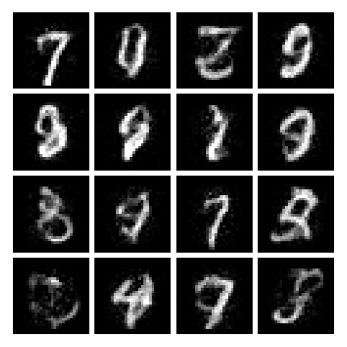

In [ ]:
samples = model.sample(16)
show_imgs(samples.cpu())


# Section 2 : transformations from latent z to image x
Starting from normal noise, we visualize the output of each NF layer.  
From left to right: we show original noise and 4 images representing the output of each of the 4 NF layers.  
We repeat for 10 images.

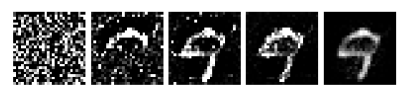

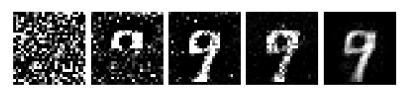

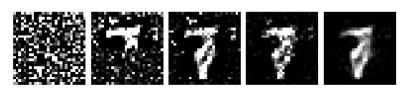

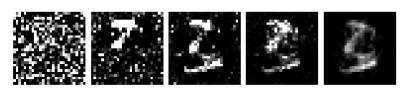

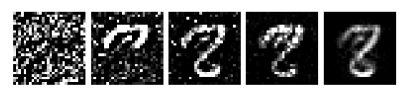

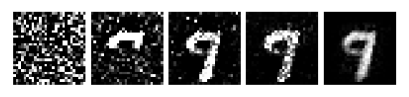

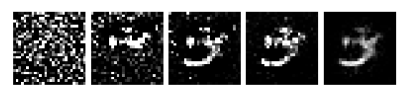

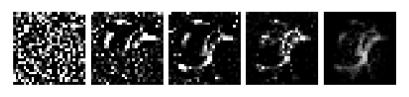

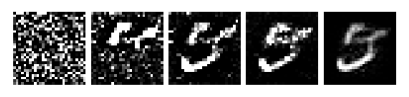

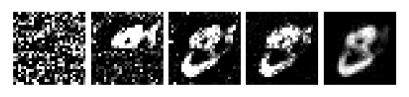

In [ ]:
imgs = model.gradual_transform(10)
imgs = torch.stack(imgs).detach()
imgs = imgs.reshape(5,10,28,28)
for i in range(10):
  sample = imgs[:,i,:,:].unsqueeze(1)
  sample = torchvision.utils.make_grid(sample, nrow=5, pad_value=128)
  sample = sample.clamp(min=0, max=255)
  np_imgs = sample.cpu().numpy()
  plt.figure(figsize=(1.5 * 5, 1.5))
  plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation='nearest')
  plt.axis('off')
plt.show()

# Section 3: Traversals in latent space
Given two images, we project them to the latent space, then create 10 latents of traversal between them $l_1 * (1-t) + t* l_2$.  
We then visualize the projection of these latents to image space.

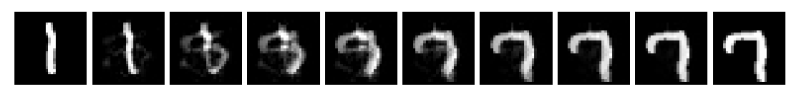

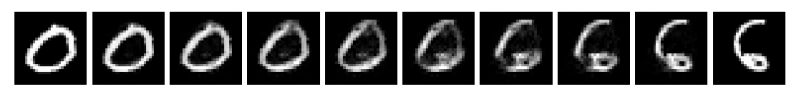

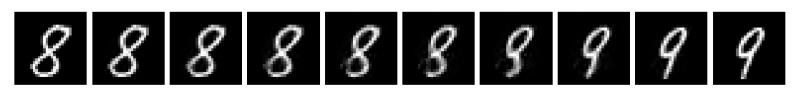

In [ ]:
num_rows = 3
num_travers = 10

imgs_all = []
digit_pairs = [(1, 7), (0, 6), (8, 9)]  # Example pairs of digits
images = {}
loader = data.DataLoader(train_set, batch_size=1, shuffle=True, drop_last=False, num_workers=1, persistent_workers=True)

for digit1, digit2 in digit_pairs:
  for _, (x, y) in enumerate(loader):
    label = y[0].item()
    if label == digit1:
      images[digit1] = x
    elif label == digit2:
      images[digit2] = x
    if digit1 in images and digit2 in images:
      break

for i, (digit1, digit2) in enumerate(digit_pairs):
  # Find two images from the dataset with the selected digits
  img1, img2 = images[digit1], images[digit2]
  # get latents for images
  with torch.no_grad():
    z1,_ = model(img1.to(model.device))
    z2,_ = model(img2.to(model.device))

    traversals = torch.linspace(0,1,num_travers)
    zs = [z2*t + (1-t)*z1 for t in traversals]
    zs = torch.cat(zs)

    # decode latents to images
    imgs = model.inverse(zs.to(model.device))
    imgs = imgs.view(num_travers, 1, 28, 28).cpu().detach()

    imgs = torchvision.utils.make_grid(imgs, nrow=num_travers, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5 * num_travers , 1.5))
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation='nearest')
    plt.axis('off')
plt.show()

## References

[1] https://towardsdatascience.com/variational-inference-with-normalizing-flows-on-mnist-9258bbcf8810

